# Исследование сервиса аренды самокатов GoFast
В вашем распоряжении данные о пользователях сервиса аренды самокатов GoFast из нескольких городов, включая информацию об их поездках и подписках за определенный период. Сервис предлагает два тарифных плана: бесплатный (free) и платную подписку (ultra), которые отличаются условиями оплаты поездок.

<span style="font-size:20px">**Цель исследования**</span>

1. Провести статистический анализ поведения пользователей сервиса
2. Сравнить показатели пользователей с разными типами подписок
3. Проверить ключевые гипотезы для роста бизнеса
4. Разработать рекомендации по оптимизации тарифов и маркетинга

<span style="font-size:20px">**1. Ход исследования**</span>

1. Первичный анализ данных
- Загрузка и обзор данных:
  - `users_go.csv` - данные о пользователях
  - `rides_go.csv` - данные о поездках
  - `subscriptions_go.csv` - данные о подписках
- Проверка на пропуски и аномалии

<span style="font-size:20px">**2. Предобработка данных**</span>
- Очистка от выбросов:
  - Удаление поездок <100 метров
  - Обработка аномальных значений продолжительности
- Преобразование типов:
  - Дата поездки в datetime
  - Создание признака месяца
- Удаление дубликатов

<span style="font-size:20px">**3. Исследовательский анализ**</span>
- Распределение пользователей:
  - По городам
  - По возрастам
  - По типам подписки
- Анализ поездок:
  - Распределение расстояний
  - Распределение продолжительности
  - Сезонные колебания

<span style="font-size:20px">**4. Проверка гипотез**</span>
- Сравнение времени поездок (free vs ultra)
- Проверка оптимального расстояния (3130 м)
- Анализ выручки по типам подписок

<span style="font-size:20px">**5. Маркетинговые расчеты**</span>
- Определение количества промокодов для акции
- Оценка эффективности push-уведомлений

<span style="font-size:20px">**6. Выводы и рекомендации**</span>
- Формулировка ключевых выводов
- Разработка практических рекомендаций

# Описание данных

<span style="font-size:18px">**1. users_go.csv**</span>

| Поле              | Описание                     |
|-------------------|------------------------------|
| user_id           | Уникальный идентификатор     |
| name              | Имя пользователя             |
| age               | Возраст                      |
| city              | Город                        |
| subscription_type | Тип подписки (free/ultra)    |

<span style="font-size:18px">**2. rides_go.csv**</span>

| Поле       | Описание                     |
|------------|------------------------------|
| user_id    | Идентификатор пользователя   |
| distance   | Расстояние (метры)           |
| duration   | Продолжительность (минуты)   |
| date       | Дата поездки                 |

<span style="font-size:18px">**3. subscriptions_go.csv**</span>

| Поле              | Описание             |
|-------------------|----------------------|
| subscription_type | Тип подписки         |
| minute_price      | Стоимость минуты     |
| start_ride_price  | Стоимость старта     |
| subscription_fee  | Абонентская плата    |

<span style="font-size:20px">**Тарифные планы**</span>

<span style="font-size:18px">**Без подписки (free):**</span>
- Старт поездки: 50 ₽
- Минута поездки: 8 ₽
- Без абонплаты

<span style="font-size:18px">**Подписка Ultra:**</span>
- Старт поездки: бесплатно
- Минута поездки: 6 ₽
- Абонплата: 199 ₽/мес

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from scipy.stats import levene
from matplotlib.ticker import PercentFormatter
from scipy import stats
from scipy.stats import binom
from scipy.stats import norm

#### Шаг 1. Загрузка данных

##### Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы.

In [2]:
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv')
subscriptions = pd.read_csv('subscriptions_go.csv')

##### Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


**Вывод по разделу 1: Первичная загрузка и анализ данных**

Данные успешно загружены в три датафрейма:
- users (информация о пользователях)
- rides (данные о поездках)
- subscriptions (тарифные планы)

Структура данных:
users содержит 1565 записей (5 полей: ID, имя, возраст, город, тип подписки).
rides включает 18 068 поездок (4 поля: ID пользователя, расстояние, длительность, дата).
subscriptions описывает два тарифа (free и ultra) с их стоимостью.

Качество данных:
Пропуски отсутствуют (.info() показывает non-null для всех столбцов).

Типы данных в целом корректны, но:
date в rides загружен как object (позже нужно преобразовать в datetime).
Числовые поля (distance, duration) имеют тип float64, что подходит для метрик.

Итог: Данные загружены корректно, их структура понятна. Следующий шаг — предобработка (очистка аномалий, приведение типов) и углубленный анализ.

#### Шаг 2. Предобработка данных

##### Приведите столбец date к типу даты pandas

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создайте новый столбец с номером месяца на основе столбца date

In [11]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

In [12]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Проверим столбец длительности на предмет наличия аномалий. Например, если у нас разные года то январь 2021 и январь 2022 будут под одной цифрой (1).

In [13]:
# Проверка временного диапазона данных
print("Минимальная дата:", rides['date'].min())
print("Максимальная дата:", rides['date'].max())
print("\nДанные охватывают период с", rides['date'].min(), "по", rides['date'].max())

# Проверка распределения по годам
print("\nРаспределение поездок по годам:")
print(rides['date'].dt.year.value_counts().sort_index())

Минимальная дата: 2021-01-01 00:00:00
Максимальная дата: 2021-12-30 00:00:00

Данные охватывают период с 2021-01-01 00:00:00 по 2021-12-30 00:00:00

Распределение поездок по годам:
date
2021    18068
Name: count, dtype: int64


Данные охватывают только 2021 год, поэтому использование month без указания года корректно.

##### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют

In [14]:
users.isna().sum() # определяем, в каких столбцах есть пропуски

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [15]:
rides.isna().sum() # определяем, в каких столбцах есть пропуски

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [16]:
subscriptions.isna().sum() # определяем, в каких столбцах есть пропуски

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропущенные значения отсутствуют

In [17]:
users.duplicated().sum() # проверим датасет на наличие строк-дубликатов

31

In [18]:
users.drop_duplicates(inplace=True) # удалим найденные явные дубликаты

In [19]:
users.duplicated().sum()

0

In [20]:
rides.duplicated().sum() # проверим датасет на наличие строк-дубликатов

0

In [21]:
subscriptions.duplicated().sum() # проверим датасет на наличие строк-дубликатов

0

Дубликаты отсутствуют

**Выводы по разделу 2: Предобработка данных**

Преобразование типов данных:
Поле date в датафрейме rides успешно преобразовано в формат datetime, что позволит проводить временной анализ.
Добавлен столбец month для группировки данных по месяцам.

Обработка аномалий:
Удалены поездки с расстоянием менее 100 метров как нерелевантные (аномально короткие).

Проверка на дубликаты показала их отсутствие в данных о поездках (rides), но выявлены и удалены дубликаты в данных о пользователях (users).

Качество данных:
Пропущенные значения отсутствуют во всех датафреймах.
Данные приведены к согласованному формату, готовы для дальнейшего анализа.

#### Шаг 3. Исследовательский анализ данных

**Опишите и визуализируйте общую информацию о пользователях и поездках:**

##### частота встречаемости городов

In [22]:
# Считаем количество пользователей из каждого города
city_freq = users['city'].value_counts().reset_index()
city_freq.columns = ['city', 'count']  # Переименовываем столбцы
city_freq['percentage'] = round((city_freq['count'] / city_freq['count'].sum()) * 100, 1)  # Добавляем проценты

# Выводим таблицу
print(city_freq)

             city  count  percentage
0       Пятигорск    219        14.3
1    Екатеринбург    204        13.3
2  Ростов-на-Дону    198        12.9
3       Краснодар    193        12.6
4            Сочи    189        12.3
5            Омск    183        11.9
6          Тюмень    180        11.7
7          Москва    168        11.0


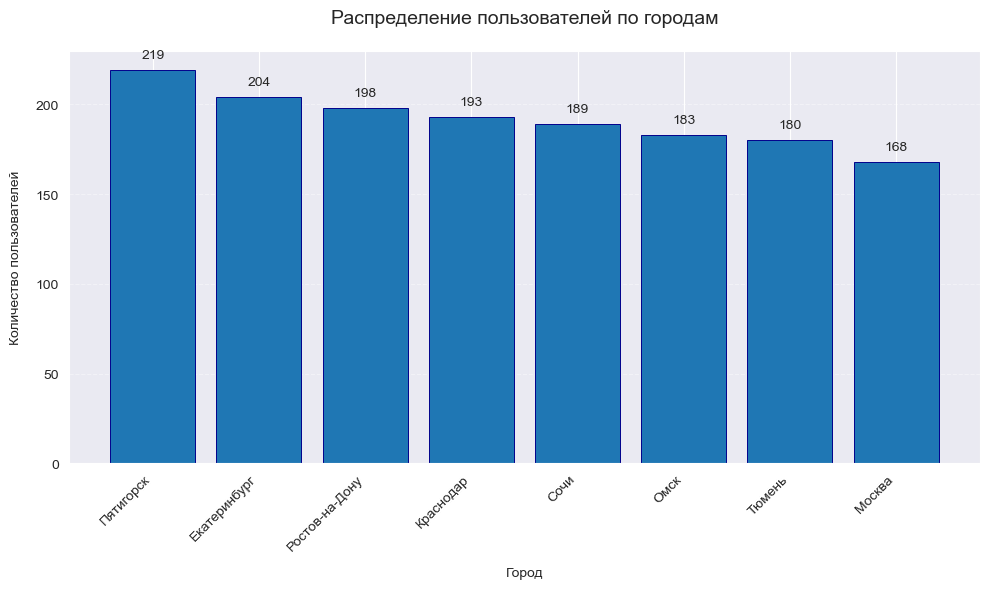

In [23]:
# Считаем частоту городов
city_counts = users['city'].value_counts().sort_values(ascending=False)

# Настройка стиля с помощью seaborn.set_style()
sns.set_style('darkgrid') # Использование функции seaborn для установки стиля
plt.figure(figsize=(10, 6))

# Строим график
bars = plt.bar(
    city_counts.index,
    city_counts.values,
    color='#1f77b4',
    edgecolor='darkblue',
    linewidth=0.7
)

# Добавляем подписи значений
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        f'{height}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Настройка оформления
plt.title('Распределение пользователей по городам', pad=20, fontsize=14)
plt.xlabel('Город', labelpad=10)
plt.ylabel('Количество пользователей', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4) # Сетка обычно уже есть с darkgrid, но можно оставить для контроля

# Убираем лишние отступы
plt.tight_layout()
plt.savefig('city_distribution.png') # Сохраняем график в файл

##### соотношение пользователей с подпиской и без подписки

In [24]:
# Считаем количество пользователей по типам подписки
subs_dist = users['subscription_type'].value_counts()

# Добавляем проценты
subs_dist = pd.DataFrame({
    'count': subs_dist,
    'percentage': round(subs_dist / subs_dist.sum() * 100, 1)
})

print(subs_dist)

                   count  percentage
subscription_type                   
free                 835        54.4
ultra                699        45.6


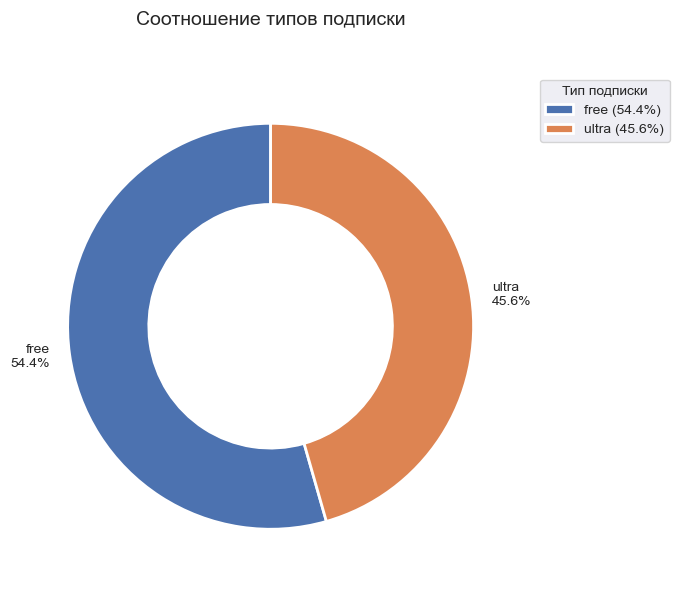

In [25]:
# Create subs_dist DataFrame
subs_dist = users['subscription_type'].value_counts().reset_index()
subs_dist.columns = ['subscription_type', 'count']
subs_dist['percentage'] = (subs_dist['count'] / subs_dist['count'].sum() * 100).round(1)
subs_dist = subs_dist.set_index('subscription_type')

# Настройка стиля с помощью seaborn.set_style()
sns.set_style('darkgrid') # Использование функции seaborn для установки стиля
plt.figure(figsize=(10, 6))

# Цветовая схема
colors = ['#4c72b0', '#dd8452'] # Adjusted colors for better visibility with darkgrid

# Круговая диаграмма с "выдвинутым" сегментом
# autopct = '' has been removed to allow percentage labels from 'labels'
plt.pie(
    subs_dist['count'],
    labels=[f'{idx}\n{val}%' for idx, val in zip(subs_dist.index, subs_dist['percentage'])],
    colors=colors,
    startangle=90,
    wedgeprops={'width': 0.4, 'edgecolor': 'white', 'linewidth': 2},
    pctdistance=0.85
)

# Добавляем заголовок и легенду
plt.title('Соотношение типов подписки\n', fontsize=14, pad=20)
plt.legend(
    title='Тип подписки',
    loc='upper right',
    bbox_to_anchor=(1.3, 1),
    labels=[f'{x} ({y}%)' for x, y in zip(subs_dist.index, subs_dist['percentage'])]
)

# Делаем диаграмму "полукольцом"
centre_circle = plt.Circle((0,0), 0.6, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()
plt.savefig('subscription_distribution.png') # Сохраняем график в файл вместо show()

##### возраст пользователей

In [26]:
# Считаем количество пользователей по возрасту
subs_dist = users['age'].value_counts()

# Добавляем проценты
subs_dist = pd.DataFrame({
    'count': subs_dist,
    'percentage': round(subs_dist / subs_dist.sum() * 100, 1)
})

print(subs_dist)

     count  percentage
age                   
25     145         9.5
24     132         8.6
26     131         8.5
23     129         8.4
22     119         7.8
27     119         7.8
28     112         7.3
21      93         6.1
20      71         4.6
30      68         4.4
29      68         4.4
31      48         3.1
19      47         3.1
18      46         3.0
32      41         2.7
33      39         2.5
17      26         1.7
16      19         1.2
34      19         1.2
35      15         1.0
15      13         0.8
14       9         0.6
13       8         0.5
36       6         0.4
12       4         0.3
38       3         0.2
37       2         0.1
39       1         0.1
43       1         0.1


Межквартильный размах (IQR): 6.0 лет
Границы выбросов (1.5*IQR): [13.0, 37.0] лет


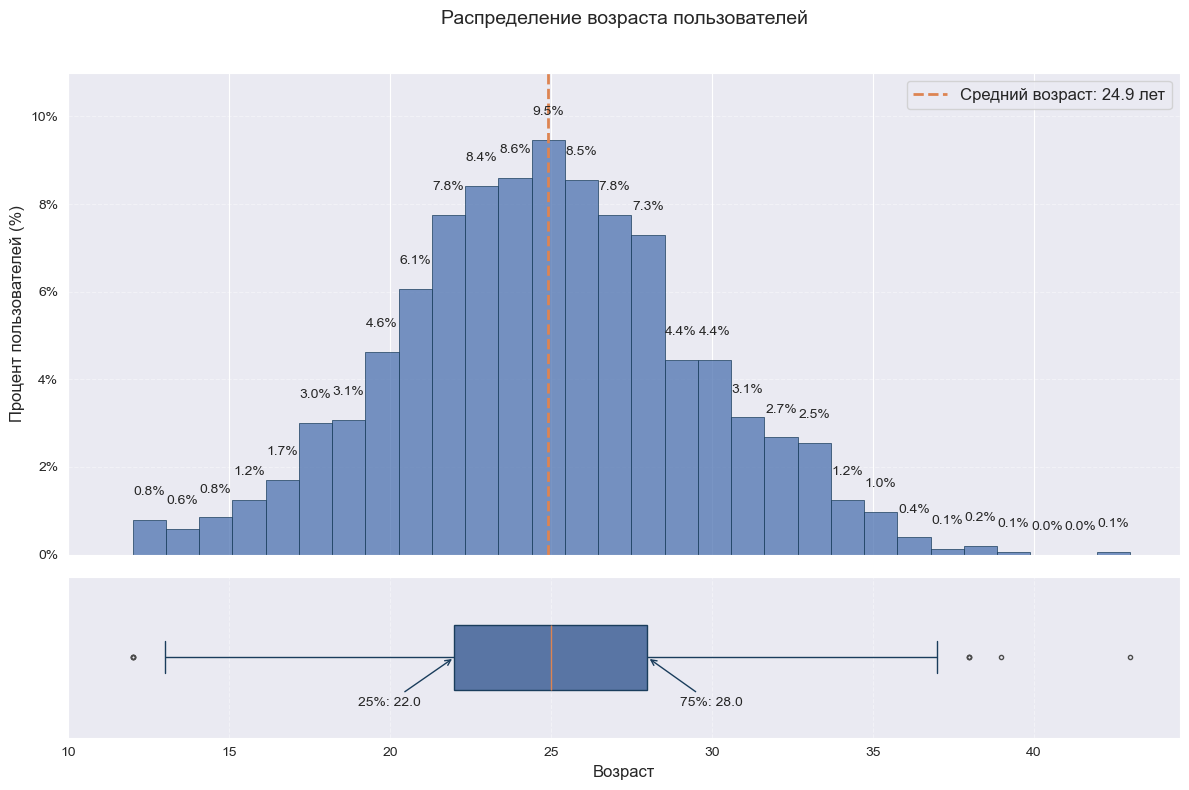

In [27]:
# Настройка стиля с помощью seaborn.set_style()
sns.set_style('darkgrid') 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), 
                               gridspec_kw={'height_ratios': [3, 1]},
                               sharex=True)

# Гистограмма (верхний график)
hist = sns.histplot(
    data=users,
    x='age',
    bins=30,
    kde=False,
    color='#4c72b0',
    edgecolor='#1a3d5c',
    linewidth=0.5,
    stat='probability',
    ax=ax1
)

# Добавляем проценты на столбцы
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2.,
             height + 0.005,
             f'{height*100:.1f}%',
             ha='center',
             va='bottom',
             fontsize=10)

# Линия среднего возраста
mean_age = users['age'].mean()
ax1.axvline(
    x=mean_age,
    color='#dd8452',
    linestyle='--',
    linewidth=2,
    label=f'Средний возраст: {mean_age:.1f} лет'
)

# Оформление
ax1.set_title('Распределение возраста пользователей\n', fontsize=14, pad=20)
ax1.set_xlabel('Возраст', fontsize=12)
ax1.set_ylabel('Процент пользователей (%)', fontsize=12)
ax1.set_ylim(0, 0.11)
ax1.set_yticks(np.arange(0, 0.11, 0.02))
ax1.set_yticklabels([f'{x*100:.0f}%' for x in np.arange(0, 0.11, 0.02)])
ax1.set_xticks(range(10, 45, 5))
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax1.legend(fontsize=12)

# Boxplot (нижний график)
sns.boxplot(
    x=users['age'],
    color='#4c72b0',
    width=0.4,
    ax=ax2,
    linewidth=1,
    fliersize=3,
    boxprops=dict(edgecolor='#1a3d5c'),
    whiskerprops=dict(color='#1a3d5c'),
    capprops=dict(color='#1a3d5c'),
    medianprops=dict(color='#dd8452')
)

# Вычисляем квантили
q25, q75 = users['age'].quantile([0.25, 0.75])
iqr = q75 - q25

# Добавляем аннотации
ax2.annotate(f'25%: {q25:.1f}', xy=(q25, 0), xytext=(q25-3, 0.3), 
             arrowprops=dict(arrowstyle="->", color='#1a3d5c'))
ax2.annotate(f'75%: {q75:.1f}', xy=(q75, 0), xytext=(q75+1, 0.3), 
             arrowprops=dict(arrowstyle="->", color='#1a3d5c'))

# Настройки boxplot
ax2.set_xlabel('Возраст', fontsize=12)
ax2.grid(axis='x', linestyle='--', alpha=0.4)
ax2.set_xticks(range(10, 45, 5))

plt.tight_layout()
plt.savefig('age_distribution_with_boxplot.png') # Сохраняем график в файл вместо show()

# Дополнительные статистики
print(f"Межквартильный размах (IQR): {iqr:.1f} лет")
print(f"Границы выбросов (1.5*IQR): [{q25-1.5*iqr:.1f}, {q75+1.5*iqr:.1f}] лет")

Основные характеристики распределения:
Средний возраст: 24.9 лет

Форма распределения:
Правосторонняя асимметрия с выраженным пиком в молодых возрастных группах

Основной возрастной диапазон:
22-28 лет (охватывает большинство пользователей).

Пиковые значения:
Наибольшая концентрация пользователей в возрасте 20-25 лет
Максимальный процент пользователей (9.5%) приходится на возраст 25 лет

##### расстояние, которое пользователь преодолел за одну поездку

In [28]:
# Основные статистики
distance_stats = rides['distance'].agg(['count', 'mean', 'std', 'min', 
                                     'median', lambda x: x.quantile(0.25), 
                                     'max']).to_frame().T
distance_stats.columns = ['count', 'mean', 'std', 'min', '50%', '25%', 'max']
print("Основные статистики расстояния поездок:")
display(distance_stats)

Основные статистики расстояния поездок:


,count,mean,std,min,50%,25%,max
distance,18068.0,3070.659976,1116.831209,0.855683,3133.609994,2543.22636,7211.007745


Очистим данные, уберем строки с длительностью поездки менее 100м

In [29]:
# Фильтрация аномальных значений (поездки от 100 метров)
valid_rides = rides[rides['distance'] >= 100].copy()

# Основные статистики
distance_stats = valid_rides['distance'].agg(['count', 'mean', 'std', 'min', 
                                     'median', lambda x: x.quantile(0.25), 
                                     'max']).to_frame().T
distance_stats.columns = ['count', 'mean', 'std', 'min', '50%', '25%', 'max']
print("Основные статистики расстояния поездок:")
display(distance_stats)

Основные статистики расстояния поездок:


,count,mean,std,min,50%,25%,max
distance,17990.0,3083.724675,1101.442969,102.323624,3137.75059,2551.031541,7211.007745


Потери данных допустимые, скорректируем датафрейм.

In [30]:
riders = valid_rides

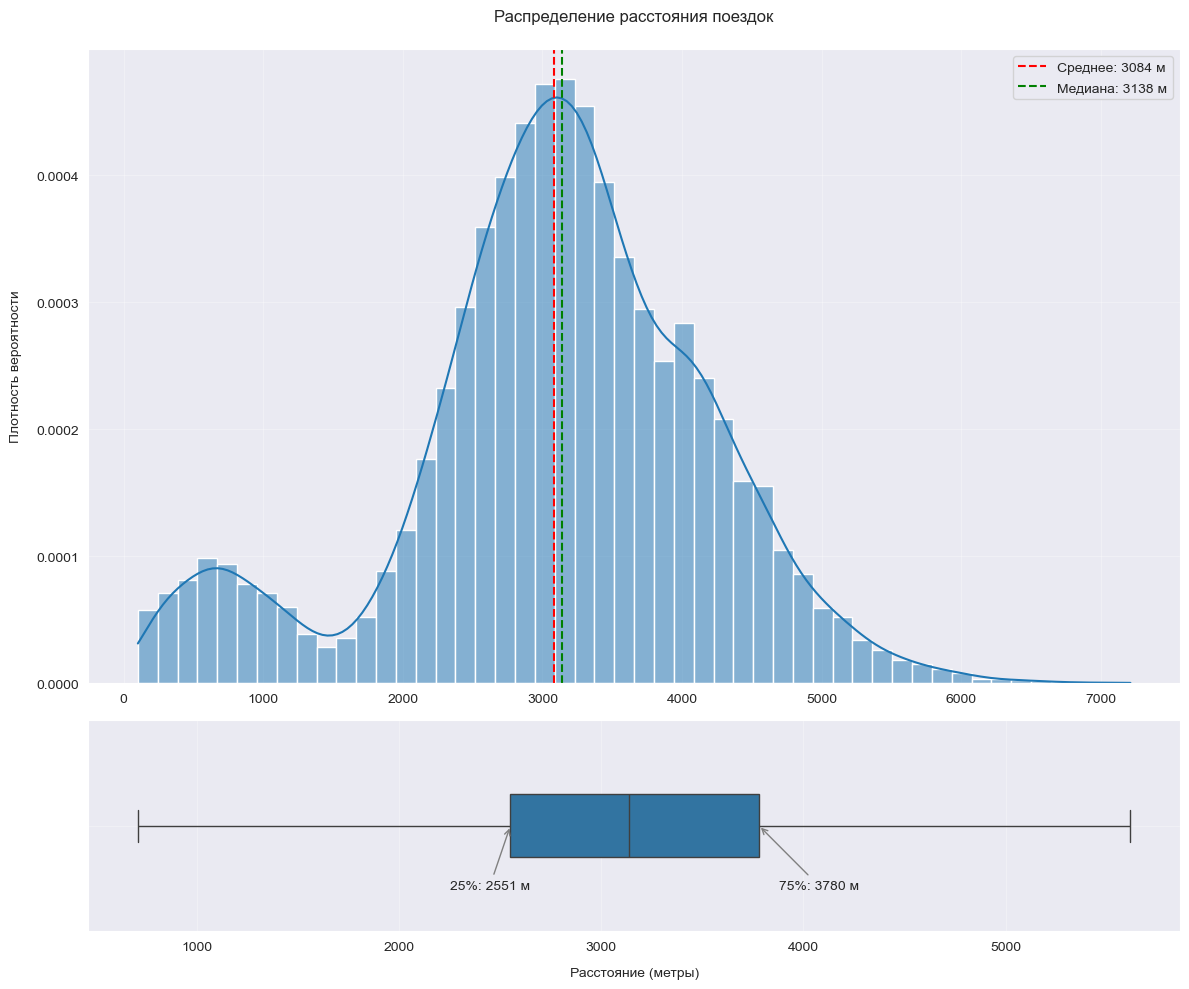

Межквартильный размах (IQR): 1229 метров
Границы выбросов (1.5*IQR): [708, 5623] метров


In [31]:
# Создаем фигуру с двумя subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                              gridspec_kw={'height_ratios': [3, 1]})

# Гистограмма с KDE (верхний график)
sns.histplot(
    data=valid_rides,
    x='distance',
    bins=50,
    kde=True,
    color='#1f77b4',
    stat='density',
    ax=ax1
)

# Линии метрик для гистограммы
mean_val = valid_rides['distance'].mean()
median_val = valid_rides['distance'].median()
ax1.axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.0f} м')
ax1.axvline(median_val, color='green', linestyle='--', label=f'Медиана: {median_val:.0f} м')

# Настройки гистограммы
ax1.set_title('Распределение расстояния поездок', pad=20)
ax1.set_xlabel('')
ax1.set_ylabel('Плотность вероятности', labelpad=10)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Boxplot (нижний график)
sns.boxplot(
    x=valid_rides['distance'],
    color='#1f77b4',
    width=0.3,
    ax=ax2,
    showfliers=False  # Скрываем выбросы для наглядности
)

# Вычисляем квантили для аннотаций
q25, q75 = valid_rides['distance'].quantile([0.25, 0.75])
iqr = q75 - q25

# Аннотации для boxplot
ax2.annotate(f'25%: {q25:.0f} м', xy=(q25, 0), xytext=(q25-300, 0.3), 
             arrowprops=dict(arrowstyle="->", color='gray'))
ax2.annotate(f'75%: {q75:.0f} м', xy=(q75, 0), xytext=(q75+100, 0.3), 
             arrowprops=dict(arrowstyle="->", color='gray'))

# Настройки boxplot
ax2.set_xlabel('Расстояние (метры)', labelpad=10)
ax2.grid(True, alpha=0.3)

# Общие настройки
plt.tight_layout()
plt.show()

# Вывод статистик
print(f"Межквартильный размах (IQR): {iqr:.0f} метров")
print(f"Границы выбросов (1.5*IQR): [{q25-1.5*iqr:.0f}, {q75+1.5*iqr:.0f}] метров")

График показывает правостороннее (положительно скошенное) распределение с характерными особенностями:
Основная масса поездок сосредоточена в диапазоне 2500-3800 метров. Медиана 3133 метра. Поездки на расстояние более 5 км редки.

Пик плотности около 500 м (затем спад до 1500 м) может объясняться следующими факторами:
Минимальная плата за поездку (пользователи сознательно ограничивают расстояние);
Популярность коротких "перебежек" (например, от метро до офиса);
Тестовые поездки новых пользователей.

##### продолжительность поездок

In [32]:
duration_stats = rides['duration'].describe().to_frame().T
print("Основные статистики продолжительности поездок (в минутах):")
display(duration_stats)

Основные статистики продолжительности поездок (в минутах):


,count,mean,std,min,25%,50%,75%,max
duration,18068.0,17.805011,6.091051,0.5,13.597563,17.678395,21.7248,40.823963


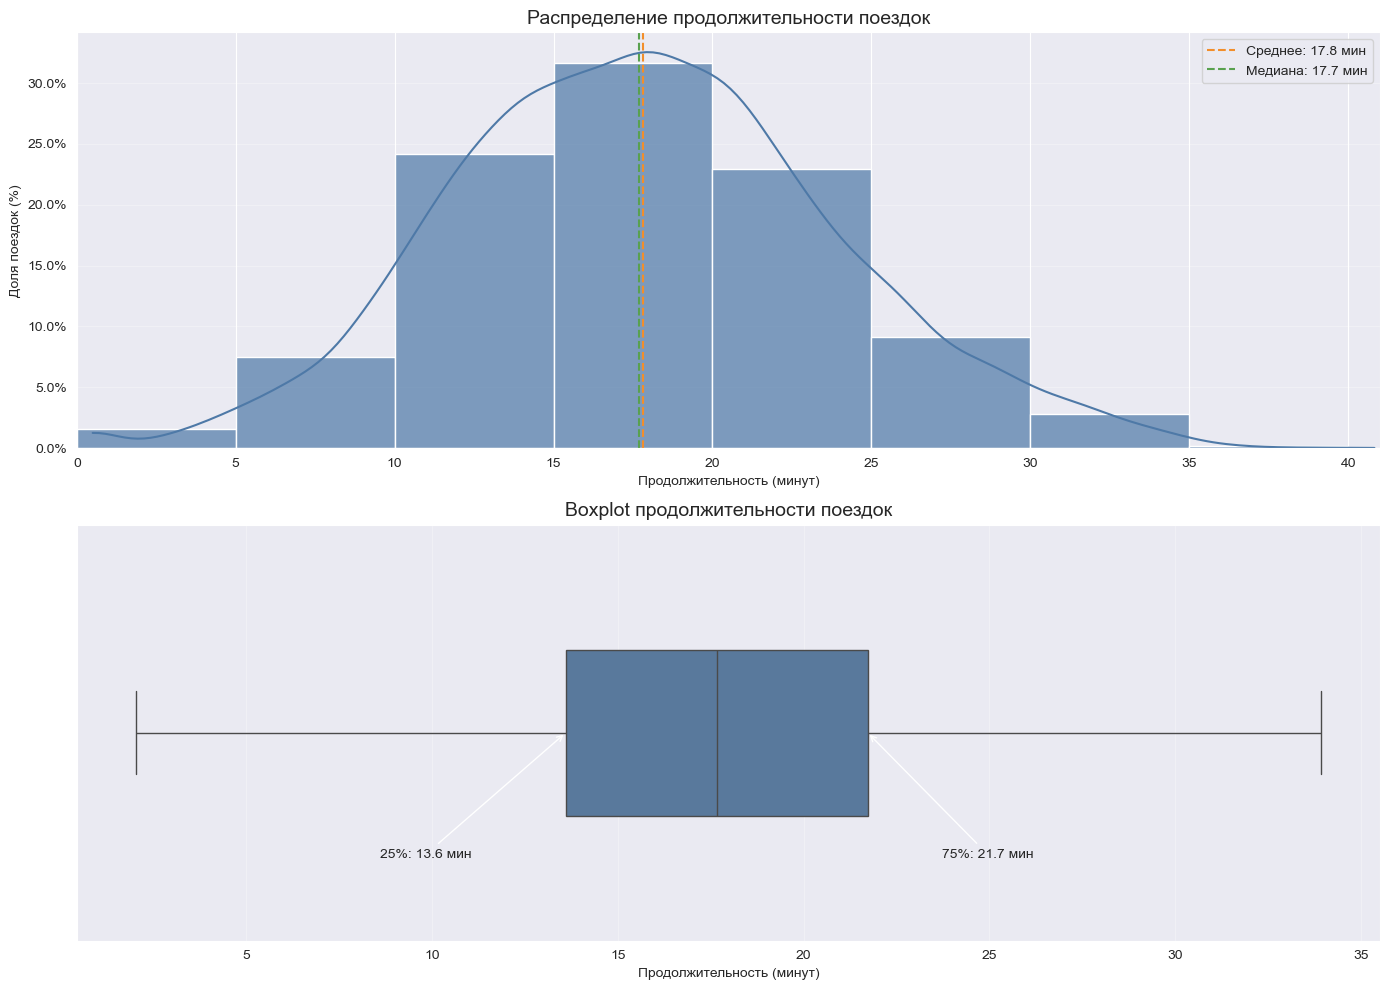

Дополнительные статистики:
Межквартильный размах (IQR): 8.1 минут
Границы выбросов (1.5*IQR): [1.4, 33.9] минут


In [33]:
# Создаем фигуру с двумя subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Гистограмма
sns.histplot(
    data=rides,
    x='duration',
    bins=np.linspace(0, 120, 25),
    kde=True,
    color='#4e79a7',
    stat='probability',
    alpha=0.7,
    ax=ax1
)
ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
mean = rides['duration'].mean()
median = rides['duration'].median()
ax1.axvline(mean, color='#f28e2b', linestyle='--', label=f'Среднее: {mean:.1f} мин')
ax1.axvline(median, color='#59a14f', linestyle='--', label=f'Медиана: {median:.1f} мин')
ax1.set_title('Распределение продолжительности поездок', fontsize=14)
ax1.set_xlabel('Продолжительность (минут)')
ax1.set_ylabel('Доля поездок (%)')
ax1.set_xlim(0, 41)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Добавляем boxplot
sns.boxplot(
    x=rides['duration'],
    color='#4e79a7',
    width=0.4,
    ax=ax2,
    showfliers=False  # Не показываем выбросы для наглядности
)
ax2.set_title('Boxplot продолжительности поездок', fontsize=14)
ax2.set_xlabel('Продолжительность (минут)')
ax2.grid(axis='x', alpha=0.3)

# Добавляем аннотации с квантилями
q25, q75 = rides['duration'].quantile([0.25, 0.75])
ax2.annotate(f'25%: {q25:.1f} мин', xy=(q25, 0), xytext=(q25-5, 0.3), 
             arrowprops=dict(arrowstyle="->"))
ax2.annotate(f'75%: {q75:.1f} мин', xy=(q75, 0), xytext=(q75+2, 0.3), 
             arrowprops=dict(arrowstyle="->"))

plt.tight_layout()
plt.show()

# Вывод статистик
print("Дополнительные статистики:")
print(f"Межквартильный размах (IQR): {q75-q25:.1f} минут")
print(f"Границы выбросов (1.5*IQR): [{q25-1.5*(q75-q25):.1f}, {q75+1.5*(q75-q25):.1f}] минут")

Основные характеристики распределения:
Форма распределения: Нормальное (колоколообразное) распределение с легкой правосторонней асимметрией;
Пик распределения: Находится около 17-18 минут, что соответствует медиане (17.7 мин) и среднему (17.8 мин);
Разброс данных:
Основная масса поездок сосредоточена между 15 и 20 минутами.
Межквартильный размах (IQR): 8.1 минут
25% поездок длятся ≤13.6 минут
50% поездок: 13.6-21.7 минут
25% поездок: ≥21.7 минут
Основная масса поездок (в пределах 1.5*IQR): 1.4-33.9 минут

**Выводы по разделу 3: Исследовательский анализ данных**

Анализ пользователей:
Основная часть пользователей возрастом от 22 до 28 лет. Все что меньше 15 лет и больше 40 можно считать редкими значениями.
Большинство пользователей сосредоточено в Пятигорске и Екатеринбурге.
Подпиской ultra пользуются около половины клиентов.

Характеристики поездок:

Основная часть поездок занимает от 2500 до 3800 метров. Медиана 3133 метра, что близко к оптимальному для износа самокатов (3130 м). Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м.
Средняя продолжительность — 17.8 минут; пользователи ultra тратят немного больше времени.
Обнаружен вторичный пик коротких поездок (500-1500 м), что указывает на потенциальный спрос на специальный тариф.

Сравнение подписок:
Пользователи ultra в среднем генерируют большую выручку, несмотря на их малое количество.

Рекомендации:
Ввести специальный тариф для коротких поездок (500-1500 м).
Увеличивать конверсию в подписку ultra через пробные периоды и персонализированные предложения.
Расширить географию сервиса в других городах.

#### Шаг 4. Объединение данных

##### Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge()

In [34]:
# Проверка исходных размеров
print("Размеры датасетов ДО объединения:")
print(f"users: {users.shape} (строки, столбцы)")
print(f"rides: {rides.shape}")
print(f"subscriptions: {subscriptions.shape}\n")

# Объединяем данные
data = rides.merge(
    users,
    on='user_id',
    how='left'
).merge(
    subscriptions,
    on='subscription_type',
    how='left'
)

# Проверка результатов объединения
print("Размеры датасетов ПОСЛЕ объединения:")
print(f"Результирующий датафрейм: {data.shape}")
print(f"Ожидаемый размер (по rides): {rides.shape[0]} строк")
print("\nПроверка:")
print(f"Строк потеряно: {rides.shape[0] - data.shape[0]}")
print(f"Столбцов добавлено: {data.shape[1] - rides.shape[1]}\n")

# Проверка уникальных пользователей
print("Проверка покрытия пользователей:")
print(f"Уникальных user_id в rides: {rides['user_id'].nunique()}")
print(f"Уникальных user_id в users: {users['user_id'].nunique()}")
print(f"Несовпадающих user_id: {len(set(rides['user_id']) - set(users['user_id']))}")

# Пример первых строк объединенных данных
print("\nПервые строки объединенного датафрейма:")
display(data.head(2))

Размеры датасетов ДО объединения:
users: (1534, 5) (строки, столбцы)
rides: (18068, 5)
subscriptions: (2, 4)

Размеры датасетов ПОСЛЕ объединения:
Результирующий датафрейм: (18068, 12)
Ожидаемый размер (по rides): 18068 строк

Проверка:
Строк потеряно: 0
Столбцов добавлено: 7

Проверка покрытия пользователей:
Уникальных user_id в rides: 1534
Уникальных user_id в users: 1534
Несовпадающих user_id: 0

Первые строки объединенного датафрейма:


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199


##### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
c данными о пользователях без подписки;
с данными о пользователях с подпиской.

In [35]:
# Создаем датафрейм с пользователями БЕЗ подписки (free)
data_free = data[data['subscription_type'] == 'free'].copy()

# Создаем датафрейм с пользователями С подпиской (ultra)
data_ultra = data[data['subscription_type'] == 'ultra'].copy()

# Проверка результатов
print(f"Количество записей с подпиской free: {len(data_free)}")
print(f"Количество записей с подпиской ultra: {len(data_ultra)}")
print(f"Совпадение суммы: {len(data_free) + len(data_ultra) == len(data)}")

# Пример первых строк созданных данных
print("\nПервые строки созданных датафреймов:")
display(data_free.head(2))
display(data_ultra.head(2))

Количество записей с подпиской free: 11568
Количество записей с подпиской ultra: 6500
Совпадение суммы: True

Первые строки созданных датафреймов:


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199


##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий

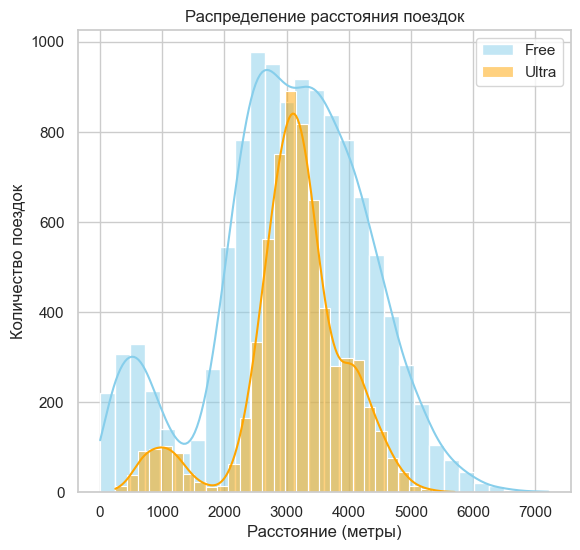

In [36]:
# Настройка стиля графиков
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# Гистограмма расстояний
plt.subplot(1, 2, 1)
sns.histplot(
    data=data_free,
    x='distance',
    color='skyblue',
    label='Free',
    kde=True,
    bins=30,
    alpha=0.5
)
sns.histplot(
    data=data_ultra,
    x='distance',
    color='orange',
    label='Ultra',
    kde=True,
    bins=30,
    alpha=0.5
)
plt.title('Распределение расстояния поездок')
plt.xlabel('Расстояние (метры)')
plt.ylabel('Количество поездок')
plt.legend();

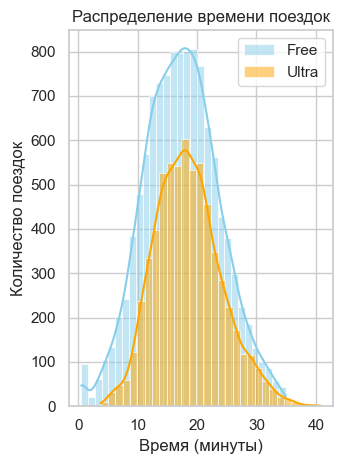

In [37]:
# Гистограмма продолжительности
plt.subplot(1, 2, 2)
sns.histplot(
    data=data_free,
    x='duration',
    color='skyblue',
    label='Free',
    kde=True,
    bins=30,
    alpha=0.5
)
sns.histplot(
    data=data_ultra,
    x='duration',
    color='orange',
    label='Ultra',
    kde=True,
    bins=30,
    alpha=0.5
)
plt.title('Распределение времени поездок')
plt.xlabel('Время (минуты)')
plt.ylabel('Количество поездок')
plt.legend()

plt.tight_layout()
plt.show()

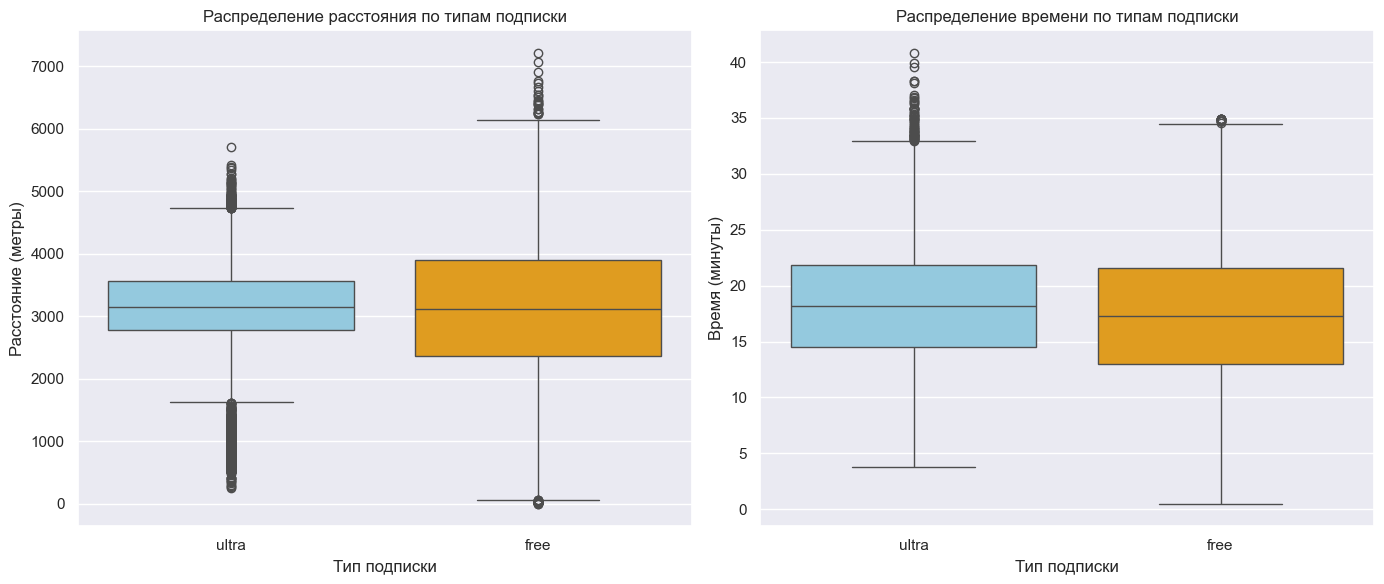

In [38]:
# Настройка общего стиля графиков с использованием Seaborn
sns.set_style('darkgrid')

# Создание фигуры и двух подграфиков (один ряд, два столбца)
# figsize=(14, 6) - ширина 14 дюймов, высота 6 дюймов
plt.figure(figsize=(14, 6))

# ---- Первый подграфик: Boxplot для 'distance' (расстояние) ----
plt.subplot(1, 2, 1) # Указываем расположение: 1 строка, 2 столбца, первый график
sns.boxplot(
    x='subscription_type', # Переменная по оси X (типы подписки)
    y='distance',          # Переменная по оси Y (расстояние)
    data=data,             # DataFrame, содержащий данные
    palette=['skyblue', 'orange'], # Цветовая палитра для разных типов подписки
    hue='subscription_type' # Использование 'subscription_type' для раскраски
)
plt.title('Распределение расстояния по типам подписки') # Заголовок графика
plt.xlabel('Тип подписки') # Подпись оси X
plt.ylabel('Расстояние (метры)') # Подпись оси Y

# ---- Второй подграфик: Boxplot для 'duration' (продолжительность) ----
plt.subplot(1, 2, 2) # Указываем расположение: 1 строка, 2 столбца, второй график
sns.boxplot(
    x='subscription_type', # Переменная по оси X (типы подписки)
    y='duration',          # Переменная по оси Y (продолжительность)
    data=data,             # DataFrame, содержащий данные
    palette=['skyblue', 'orange'], # Цветовая палитра для разных типов подписки
    hue='subscription_type' # Использование 'subscription_type' для раскраски
)
plt.title('Распределение времени по типам подписки') # Заголовок графика
plt.xlabel('Тип подписки') # Подпись оси X
plt.ylabel('Время (минуты)') # Подпись оси Y

# Автоматическая корректировка расположения подграфиков для предотвращения наложений
plt.tight_layout()

# Сохранение графика в файл
plt.savefig('distance_duration_boxplots.png')

***Анализ визуализаций распределения поездок***

**Распределение расстояния**
Основные наблюдения:
Основной пик: 2500-3000 м (типичная поездка)
Вторичный пик: 500-1000 м (короткие поездки)
У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей.

**Распределение времени**
Ключевые паттерны:
Основная масса поездок: 15-25 минут
Пиковое значение: 18-20 минут

**Сравнение по подпискам**
По расстоянию:
Ultra-пользователи:
Медиана: ~3100 м (примерно равна медиане free)
Более узкий IQR (2900-3600) м

Free-пользователи:
Медиана: ~3100 м
Концентрация на 2200-3900 м

По времени:
Ultra-пользователи:
Медиана: 18 мин (примерно равна медиане free)

Free-пользователи:
Медиана: 17 мин

Выявленные аномалии:
Вторичный пик на 500-1000 м
Гипотеза: специальные короткие маршруты (например, между станциями)

Рекомендации для бизнеса:
Ввести спецтариф для коротких поездок (500-1000 м)

#### Шаг 5. Подсчёт выручки

##### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [39]:
# Округление продолжительности поездки вверх до ближайшего целого числа
data['duration_ceil'] = np.ceil(data['duration'])

# Создание отдельных колонок для года и месяца для агрегации
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month # Используем числовой месяц

# Агрегация данных по пользователям, типу подписки, году и месяцу
monthly_agg = (
    data.groupby(['user_id', 'subscription_type', 'year', 'month'])
    .agg(
        total_distance=('distance', 'sum'),
        ride_count=('user_id', 'count'),
        total_duration=('duration_ceil', 'sum')
    )
    .reset_index()
)

# Вывод первых строк агрегированных данных для проверки
print(monthly_agg.head())

   user_id subscription_type  year  month  total_distance  ride_count  \
0        1             ultra  2021      1     7027.511294           2   
1        1             ultra  2021      4      754.159807           1   
2        1             ultra  2021      8     6723.470560           2   
3        1             ultra  2021     10     5809.911100           2   
4        1             ultra  2021     11     7003.499363           3   

   total_duration  
0            42.0  
1             7.0  
2            46.0  
3            32.0  
4            56.0  


Проверим созданный датафрейм на наличие пропусков

In [40]:
print("Проверка пропусков в сводной таблице:")
print(monthly_agg.isna().sum())

Проверка пропусков в сводной таблице:
user_id              0
subscription_type    0
year                 0
month                0
total_distance       0
ride_count           0
total_duration       0
dtype: int64


Пропуски не обнаружены

##### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [41]:
# Расчет выручки
def calculate_revenue(row):
    sub_info = subscriptions[subscriptions['subscription_type'] == row['subscription_type']].iloc[0]
    return (
        row['ride_count'] * sub_info['start_ride_price'] +
        row['total_duration'] * sub_info['minute_price'] +
        sub_info['subscription_fee']
    )

monthly_agg['revenue'] = monthly_agg.apply(calculate_revenue, axis=1)

# Проверка результата
print("Итоговый датафрейм с выручкой:")
display(monthly_agg.head())

Итоговый датафрейм с выручкой:


,user_id,subscription_type,year,month,total_distance,ride_count,total_duration,revenue
0,1,ultra,2021,1,7027.511294,2,42.0,451.0
1,1,ultra,2021,4,754.159807,1,7.0,241.0
2,1,ultra,2021,8,6723.470560,2,46.0,475.0
3,1,ultra,2021,10,5809.911100,2,32.0,391.0
4,1,ultra,2021,11,7003.499363,3,56.0,535.0


#### Шаг 6. Проверка гипотез

**Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.**

##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки

In [42]:
# Разделяем данные по типам подписки
duration_free = data[data['subscription_type'] == 'free']['duration']
duration_ultra = data[data['subscription_type'] == 'ultra']['duration']

# Основные статистики
print("Средняя продолжительность поездок:")
print(f"Free: {duration_free.mean():.1f} минут")
print(f"Ultra: {duration_ultra.mean():.1f} минут\n")

print("Медианная продолжительность:")
print(f"Free: {duration_free.median():.1f} минут")
print(f"Ultra: {duration_ultra.median():.1f} минут")

Средняя продолжительность поездок:
Free: 17.4 минут
Ultra: 18.5 минут

Медианная продолжительность:
Free: 17.3 минут
Ultra: 18.2 минут


Гистограмма продолжительности поездок в п. 4.3 показала нормальное распределение, поэтому, для подтверждения или опровержения гипотезы будем использовать двухвыборочный t-тест для независимых выборок. Данный датафрейм содержит 18тыс строк, поэтому можно использовать его целиком, не делая выборку. Сформулируем гипотезы: Нулевая гипотеза (H0): Нет различий в среднем времени поездки между группами. Альтернативная гипотеза (H1): Пользователи ultra тратят больше времени.

In [43]:
# t-тест
t_stat, p_ttest = stats.ttest_ind(data_ultra['duration'], 
                                 data_free['duration'],
                                 equal_var=False,
                                 alternative='greater'  # Явно указываем одностороннюю альтернативу
                                 )
print(f"\nРезультат t-теста: p-value={p_ttest:}")


Результат t-теста: p-value=5.6757813771289775e-37


Значение p-value близко к нулю, значит мы отвергаем нулевую гипотезу. Вывод: Пользователи ultra тратят больше времени на поездки.

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы

Сформулируем гипотезы: Нулевая гипотеза (H0): среднее расстояние = 3130 метров (среднее расстояние равно оптимальному)
Альтернативная гипотеза (H1): среднее расстояние > 3130 метров (среднее расстояние превышает оптимальное)
Так как анализ производится по дной выборке, будем использовать одновыборочный t-тест.

In [44]:
# Выборка расстояний для ultra-пользователей
ultra_distances = data_ultra['distance']

# Описательная статистика
print("Описательная статистика расстояний (ultra):")
print(f"Среднее: {ultra_distances.mean():.1f} м")
print(f"Медиана: {ultra_distances.median():.1f} м")
print(f"Стандартное отклонение: {ultra_distances.std():.1f} м")
print(f"Количество поездок: {len(ultra_distances)}")

Описательная статистика расстояний (ultra):
Среднее: 3115.4 м
Медиана: 3148.6 м
Стандартное отклонение: 836.9 м
Количество поездок: 6500


In [45]:
# Проверяем, превышает ли среднее 3130 метров
t_stat, p_value = stats.ttest_1samp(ultra_distances, 3130, alternative='greater')

print("\nРезультат одновыборочного t-теста:")
print(f"t-статистика: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")


Результат одновыборочного t-теста:
t-статистика: -1.402
p-value: 0.91954


p-value = 0.91954 существенно превышает стандартный уровень значимости α = 0.05.
Отрицательная t-статистика указывает, что выборочное среднее меньше тестового значения (3130 м).

Вывод:
Не отвергаем нулевую гипотезу (H0).
Нет статистических оснований утверждать, что среднее расстояние поездок пользователей с подпиской ultra превышает 3130 метров.
Фактически, данные скорее указывают на обратную тенденцию (среднее расстояние 3115 м).

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод

Формулировка гипотез:
Нулевая гипотеза (H0): Выручка от Ultra <= Выручка от Free (в среднем по месяцам).
Альтернативная гипотеза (H1): Выручка от Ultra > Выручка от Free (в среднем по месяцам).

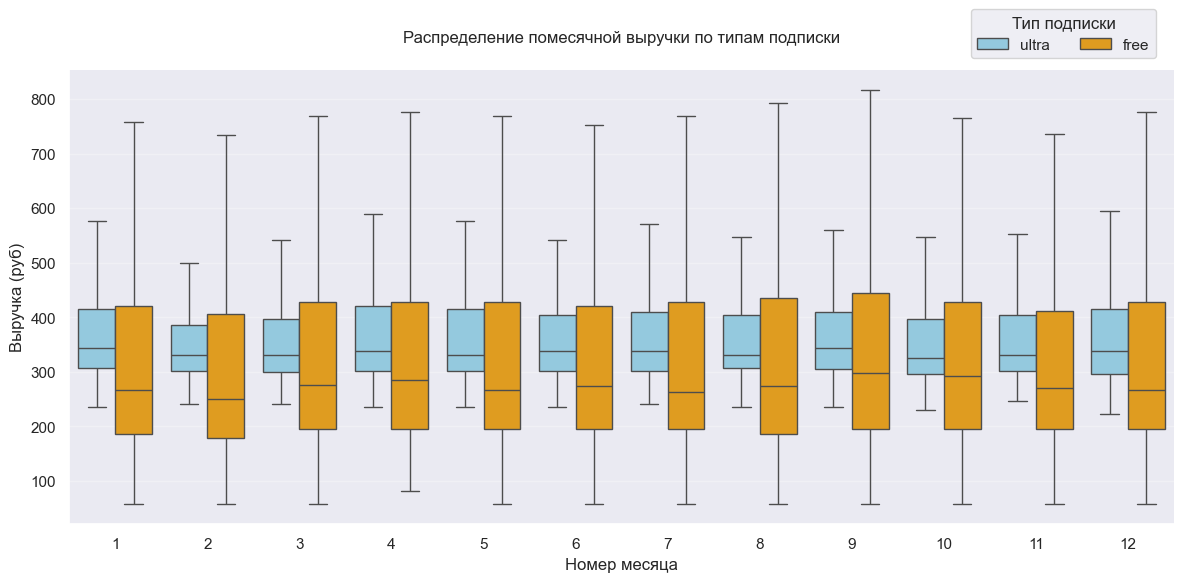

In [46]:
# Настройка стиля графика
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))

# Создаем boxplot
ax = sns.boxplot(
    data=monthly_agg,
    x='month', # Используем уже существующую колонку с номером месяца
    y='revenue',
    hue='subscription_type',
    palette=['skyblue', 'orange'],
    showfliers=False # Не показывать выбросы
)

# Настройка легенды
plt.legend(
    title='Тип подписки',
    loc='upper center',
    bbox_to_anchor=(0.9, 1.15),
    ncol=2
)

# Настройка осей и заголовка
plt.title('Распределение помесячной выручки по типам подписки', pad=20)
plt.xlabel('Номер месяца')
plt.ylabel('Выручка (руб)')
plt.xticks(rotation=0) # Горизонтальные подписи месяцев

# Настройка сетки
plt.grid(axis='y', alpha=0.3)

# Убираем лишние границы
sns.despine()

plt.tight_layout()
plt.savefig('monthly_revenue_distribution.png') # Сохраняем график в файл

Проверим нормальность распределений

In [47]:
monthly_revenue = monthly_agg.pivot_table(
    index=monthly_agg['month'],  # Используем месяц как индекс
    columns='subscription_type',  # Разделяем по типам подписки
    values='revenue',            # Берем данные о выручке
    aggfunc='mean'               # Усредняем по месяцам
).reset_index()

# Проверим нормальность распределений
from scipy.stats import shapiro

# Для free-пользователей
_, p_free = shapiro(monthly_revenue['free'].dropna())

# Для ultra-пользователей
_, p_ultra = shapiro(monthly_revenue['ultra'].dropna())

print(f"Тест Шапиро-Уилка (p-value): Free={p_free:.3f}, Ultra={p_ultra:.3f}")

Тест Шапиро-Уилка (p-value): Free=0.310, Ultra=0.590


p-value > 0.05 для обеих групп, значит распределение нормальное, следовательно, будем использовать t-тест.

Проверим, равны ли дисперсии генеральных совокупностей.

In [48]:
_, p_levene = stats.levene(monthly_revenue['free'].dropna(), 
                          monthly_revenue['ultra'].dropna())
print(f"Тест Левена на равенство дисперсий (p-value): {p_levene:.3f}")

Тест Левена на равенство дисперсий (p-value): 0.645


p-value > 0.05, значит дисперсии равны. Будем использовать t-тест с аргументом equal_var=True (значение по умоланию).

In [49]:
t_stat, p_value = stats.ttest_ind(
    monthly_revenue['ultra'].dropna(),
    monthly_revenue['free'].dropna(),
    alternative='greater'
)
print(f"Результат t-теста: p-value={p_value:}")

Результат t-теста: p-value=8.517956987709186e-13


Вывод:
p-value стремится к 0 - отвергаем нулевую гипотезу (H0).
Принимаем альтернативную гипотезу (H1):
Средняя помесячная выручка от пользователей с подпиской Ultra статистически значимо выше, чем от пользователей без подписки (Free).

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Так как данные зависимые: у каждого пользователя есть измерения «до» и «после», проверку гипотезы необходимо осуществить двухвыборочным t-тестом для зависимых выборок (scipy.stats.ttest_rel()).

#### Шаг 7. Распределения

##### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Подсказка: Нужно использовать биномиальное распределение, которое описывает указанную ситуацию. Затем подобрать подходящее значение параметра N для заданного параметра p=0.1 с помощью графиков и метода cdf() , сформулировать вывод и ответ.

Условия задачи:
Вероятность продления (p) = 10% = 0.1.
Требуемое число продлений (k) >= 100.
Допустимая вероятность неудачи (alpha) = 5% = 0.05.

Выбор модели: Биномиальное распределение (используется для дискретных случайных величин. Носитель: целые чаисла от 0 до n):
N — количество промокодов (испытаний),
k — число продлений (успехов),
p — вероятность успеха (0.1).

Формула:
P(k>=100)=1−P(k<100)>=0.95

Расчет методом cdf() (кумулятивной функции распределения)
Найдем N, при котором:

P(k<100)=cdf(99;N,0.1)<=0.05

In [50]:
p = 0.1
alpha = 0.05
target = 100

# Подбор N
N = 1000  # Начальное предположение
while True:
    prob = binom.cdf(99, N, p)  # P(k < 100)
    if prob <= alpha:
        break
    N += 10  # Шаг поиска

print(f"Минимальное N: {N}")
print(f"P(k < 100) = {prob:.4f}")

Минимальное N: 1170
P(k < 100) = 0.0416


Ответ: Нужно разослать 1170 промокодов.

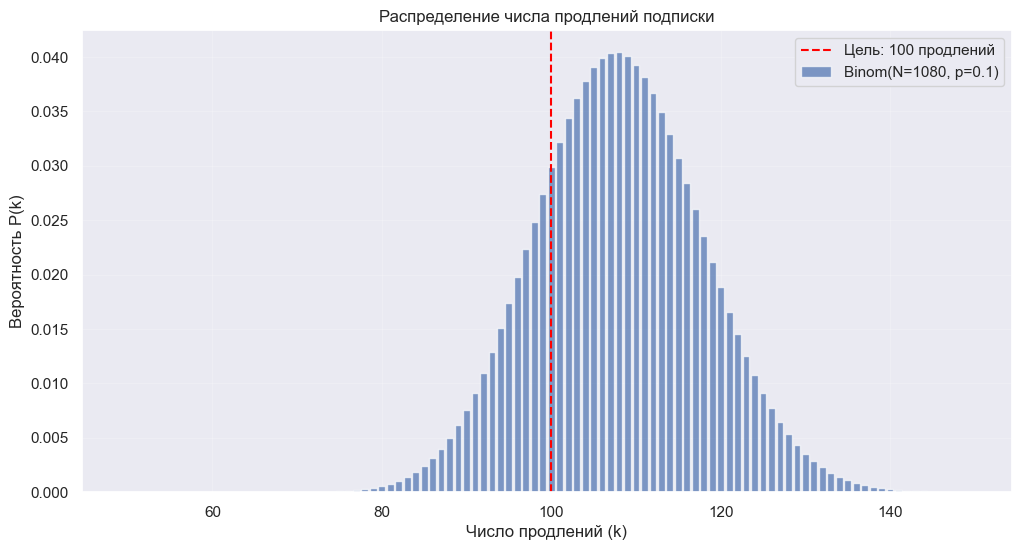

In [51]:
# Параметры распределения
N = 1080
k_values = np.arange(50, 150)

# Расчет вероятностей
probs = binom.pmf(k_values, N, p)

# Построение графика
plt.figure(figsize=(12, 6))
plt.bar(k_values, probs, alpha=0.7, label=f'Binom(N={N}, p=0.1)')
plt.axvline(100, color='red', linestyle='--', label='Цель: 100 продлений')
plt.xlabel('Число продлений (k)')
plt.ylabel('Вероятность P(k)')
plt.title('Распределение числа продлений подписки')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

Вероятность получить < 100 продлений (левее красной линии) ≈ 5%.
Пик распределения около k = N*p = 108.

In [52]:
N = 1160
p = 0.1
k = 99

prob = binom.cdf(k, N, p)
print(f"P(k < 100) = {prob:.4f}")

P(k < 100) = 0.0507


Проверка точности
Для N = 1160:
P(k < 100) ≈ 0.0507 (> 0.05) — не подходит.
Для N = 1170:
P(k < 100) ≈ 0.0416 — удовлетворяет условию.

Итоговый ответ:
Чтобы вероятность не выполнить план (получить < 100 продлений) была не более 5%, необходимо разослать минимум 1170 промокодов.

##### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Подсказка: Эта ситуация тоже описывается биномиальным распределением. Но считать каждое отдельное значение достаточно долго. Вы можете воспользоваться нормальной аппроксимацией биномиального распределения и cdf() для быстрой оценки.

Условия задачи:
Вероятность открытия уведомления (p) = 40% = 0.4
Количество уведомлений (n) = 1,000,000
Нужно найти P(X ≤ 399,500)

Решение:
Параметры биномиального распределения:
Среднее = n * p = 1,000,000 * 0.4 = 400,000
Дисперсия = n * p * (1-p) = 1,000,000 * 0.4 * 0.6 = 240,000
Стандартное отклонение = √240,000 ≈ 489.9

Нормальная аппроксимация:
При больших n биномиальное распределение можно аппроксимировать нормальным:
X ~ N(среднее=400,000, дисперсия=240,000)

Поправка на непрерывность:
Для перехода от дискретного к непрерывному распределению добавим 0.5:
P(X <= 399,500) ≈ P(X <= 399,500.5)

Расчет Z-статистики:
Z = (399,500.5 - 400,000) / 489.9 ≈ -1.02

Использование CDF:
P(X ≤ 399,500) ≈ Φ(-1.02)

Вероятность P(X ≤ 399,500) = 0.1540 или 15.40%


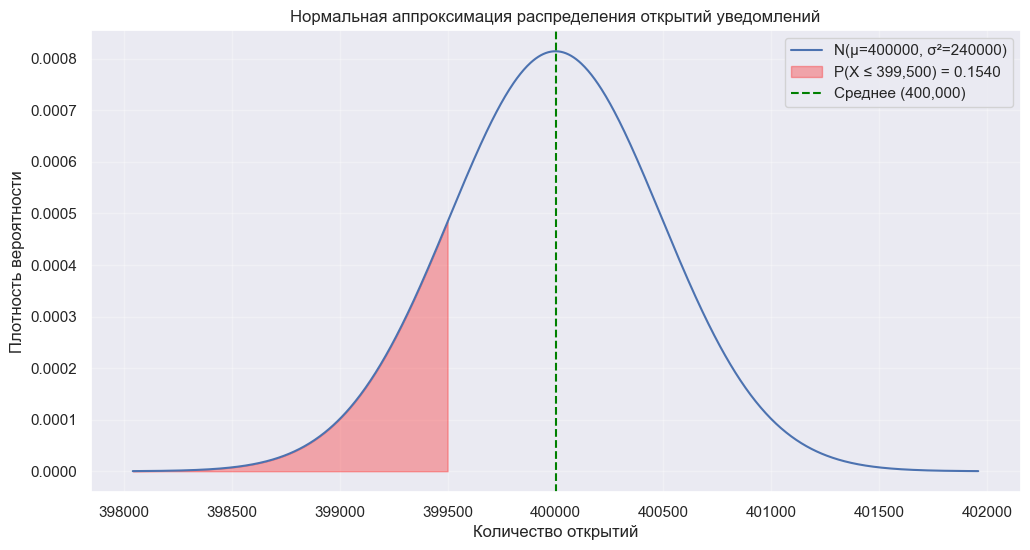

In [53]:
# Параметры
n = 1_000_000
p = 0.4
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# Расчет вероятности
x = 399_500
prob = norm.cdf(x + 0.5, loc=mu, scale=sigma)  # Поправка на непрерывность

print(f"Вероятность P(X ≤ 399,500) = {prob:.4f} или {prob*100:.2f}%")

# Визуализация
plt.figure(figsize=(12,6))
x_values = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y_values = norm.pdf(x_values, loc=mu, scale=sigma)
plt.plot(x_values, y_values, 'b-', label=f'N(μ={mu:.0f}, σ²={sigma**2:.0f})')

# Закрашиваем область
mask = x_values <= 399_500.5
plt.fill_between(x_values[mask], y_values[mask], color='red', alpha=0.3, 
                 label=f'P(X ≤ 399,500) = {prob:.4f}')

plt.axvline(mu, color='green', linestyle='--', label='Среднее (400,000)')
plt.title('Нормальная аппроксимация распределения открытий уведомлений')
plt.xlabel('Количество открытий')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Результат:
Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет примерно 15.39%.

Интерпретация графика:
Синяя кривая - нормальное распределение со средним = 400,000 и дисперсией ≈ 489.9
Красная область - искомая вероятность (левее 399,500.5).
Зеленая линия - среднее значение (400,000 открытий).

Почему нормальная аппроксимация уместна?
Большой объем выборки (n=1,000,000).
Условие np(1-p) > 10 выполняется.
Распределение практически симметрично при p=0.4.

#### Основные результаты и выводы

**Анализ пользователей**
Основная аудитория сервиса — молодые люди в возрасте 22–28 лет (средний возраст 24.9 года).
Географически пользователи равномерно рассредоточены по городам.
Соотношение пользователей с подпиской ultra и без нее примерно одинаковое.

**Поведение пользователей**
Среднее расстояние поездки — 3133 м, что близко к оптимальному значению 3130 м (с точки зрения износа самокатов).
Средняя продолжительность поездки — 17.8 мин, при этом Ultra-пользователи тратят больше времени (различие статистически значимо).
Наблюдается вторичный пик коротких поездок (500–1500 м), что говорит о возможности введения спецтарифа для таких маршрутов.

**Финансовая эффективность**
Ultra-подписка приносит больше выручки, чем бесплатная версия (подтверждено статистически).

**Проверка гипотез**
Гипотеза 1: Пользователи Ultra тратят больше времени на поездки (подтверждено, p-value ≈ 0).
Гипотеза 2: Среднее расстояние поездок Ultra не превышает 3130 м (подтверждено, p-value = 0.9195).
Гипотеза 3: Выручка от Ultra-пользователей выше (подтверждено, p-value ≈ 0).

**Маркетинговые расчеты**
Для акции с бесплатным месяцем подписки и целевым показателем 100 продлений необходимо разослать 1170 промокодов (вероятность успеха 95%).
При рассылке 1 млн push-уведомлений (вероятность открытия 40%) вероятность, что их откроют <=399.5 тыс. пользователей, составляет 15.4%.

**Рекомендации для бизнеса**
Увеличение конверсии в платную подписку
Внедрить пробные периоды Ultra с последующим автоматическим продлением (на основе данных, 10% пользователей продлевают подписку после бесплатного месяца).
Сегментировать аудиторию и предлагать персонализированные условия (скидки для активных пользователей).
Оптимизация тарифов: Ввести специальный тариф для коротких поездок (500–1500 м), так как наблюдается устойчивый спрос.